<font size=6 color=black>__Part A__</font>

In [278]:
#Function that returns Euclidean distance of two vectors
import numpy as np
import pandas as pd
from scipy.spatial import distance
from scipy import stats
import matplotlib.pyplot as plt
from heapq import nsmallest
import statistics
import scipy.stats as st
from statistics import mode
import seaborn as sns
import math

def Euclidean(a, b):
    dist = distance.euclidean(a, b)
    return dist

In [2]:
#Function that returns Manhattan distance of two vectors
def Manhattan(a, b):
    dist = distance.cityblock(a, b)
    return dist

In [3]:
#Function that returns accuracy and generalization error of two vectors
def accu_error(x, x_predict):
    g_error = np.mean((np.subtract(x, x_predict))**2)
    accu = 1 - g_error
    return (accu, g_error)

In [4]:
#Function that return the distance using the specified formula
def calculateDistance(formula,a,b):
    if(formula == 'Euclidean'):
        return Euclidean(a,b)
    else:
        return Manhattan(a,b)

In [288]:
#calculate tp, fp, tn, fn
def values(x, x_predict):
    true_positive = 0
    false_positive = 0
    true_negative = 0
    false_negative = 0
    for i in range(len(x)):
        if np.logical_and(x_predict[i] == 1, x[i] == 1):
            true_positive += 1
        if np.logical_and(x_predict[i] == 1, x[i] == 0):
            false_positive += 1
        if np.logical_and(x_predict[i] == 0, x[i] == 0):
            true_negative += 1
        if np.logical_and(x_predict[i] == 0, x[i] == 1):
            false_negative += 1
    #print(true_positive)
    #print(false_negative)
    if(true_positive+false_negative == 0):
        tpr = 0
    else:
        tpr = (true_positive)/(true_positive+false_negative)
    if(false_positive+true_negative == 0):
        fpr = 0
    else:
        fpr = (false_positive)/(false_positive+true_negative)
    return [true_positive, false_positive, true_negative, false_negative, tpr, fpr]

In [6]:
#Function to compute precision
def precision(x, x_predict):
    tp = values(x, x_predict)[0]
    fp = values(x, x_predict)[1]
    if(tp+fp == 0):
        return 0
    else:
        precisions = tp/(tp+fp)
    return precisions

#Function to compute recall
def recall(x, x_predict):
    tp = values(x, x_predict)[0]
    fn = values(x, x_predict)[3]
    if(tp+fn == 0):
        return 0
    else: 
        recall = tp/(tp+fn)
    return recall

#Function to compute f1
#def f1_score(x, x_predict):
#    f1 = (values(x, x_predict)[0])/(values(x, x_predict)[0]+((values(x, x_predict)[3]+values(x, x_predict)[1])/2))
#    return f1
def f1_score(x, x_predict):
    if((precision(x,x_predict)+recall(x,x_predict)) == 0):
        return 0
    else:
        f1 = 2*((precision(x,x_predict)*recall(x,x_predict))/(precision(x,x_predict)+recall(x,x_predict)))
    return f1

In [7]:
#Function to compute confusion matrix
def confusion_matrix(x, x_predict):
    confusion_matrix = [[], []]
    confusion_matrix[0].append(values(x, x_predict)[2])
    confusion_matrix[0].append(values(x, x_predict)[1])
    confusion_matrix[1].append(values(x, x_predict)[3])
    confusion_matrix[1].append(values(x, x_predict)[0])
    return np.asarray(confusion_matrix)

In [299]:
#get fpr, tpr lists
def rate_lists(formula, n_neighbors, X, X_train, y): # X is initial X dataframe, X_train is used to predict
    predictions = []
    temp = []
    threshold = np.array([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
    occurance_count = 0
    prediction = []
    predictions_threshold = [[],[],[],[],[],[],[],[]]
    tpr_list = []
    fpr_list = []
    X = X.to_numpy()
    X_train = X_train.to_numpy()
    for i in range(len(X)):
        occurance_count = 0
        dist = []
        label = []
        prediction = []
        for j in range(len(X_train)):
            dist.append([calculateDistance(formula, X[i], X_train[j]), j])
        
        dist = sorted(dist)
        
        for j in range(n_neighbors):
            index = dist[j][1]
            label.append(y[index])
        
        most_occur = mode(label)
        for m in label:
            if m == most_occur:
                occurance_count += 1
        for l in threshold:
            if ((occurance_count/n_neighbors) >= l):
                prediction.append(most_occur)
            else:
                if most_occur == 1:
                    prediction.append(0)
                else:
                    prediction.append(most_occur)
        for p in range(0,11):
            predictions_threshold[p].append(prediction[p])
    for i in range(len(predictions_threshold)):
        tpr_list.append(values(y, predictions_threshold[i])[4])
        fpr_list.append(values(y, predictions_threshold[i])[5])

    return [tpr_list, fpr_list]

In [261]:
#Function to generate ROC curve
def ROC_curve(fpr_list, tpr_list):
    plt.figure(figsize = (10, 6))
    plt.plot(fpr_list, tpr_list, color='orange', linewidth=5)
    #print(fpr, tpr)
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('false positive rate')
    plt.ylabel('true positive rate')
    plt.title('ROC Curve')

In [9]:
#Function to calculate the area under ROC
def auc(fpr_list, tpr_list):
    auc = np.trapz(tpr_list, fpr_list)
    return auc

In [73]:
#KNN_Classifier Model class
class KNN_Classifier:
#fit function
    def fit(self, X, Y, n_neighbors, weights, kwargs):
        self.X = X.reset_index(drop=True).to_numpy()
        self.Y = Y
        self.n_neighbors = n_neighbors
        self.weights = weights
        self.kwargs = kwargs['Formula']

#predict function: check every element in X_predict against X 
#and use n_neighbors to return a new list where predictions are stored
    def predict(self, X_predict):
        X_predict = X_predict.to_numpy()
        predictions = []
        temp = []
        label = []
        most_occur = 0
        prob = 0
        for i in range(len(X_predict)):
            label = []
            temp = []
            for j in range(len(self.X)):
                dist = calculateDistance(self.kwargs,X_predict[i], self.X[j])
                temp.append([dist, j]) 
            temp = nsmallest(self.n_neighbors, temp)
            index_of_min_dist = [item[1] for item in temp]
            for k in range(len(index_of_min_dist)):
                label.append(self.Y[index_of_min_dist[k]])
            most_occur = mode(label)
            predictions.append(most_occur)
            
        return np.asarray(predictions)
    def init(self):
        return None

#knn = KNN_Classifier()
#knn.fit([1,1,0], [1,1,0], 3, 'uniform', 0)
#knn.predict([1,0,0])

<font size=6 color=black>__Part B__</font>

In [238]:
#read the dataset
df = pd.read_csv('winequality-white.csv', sep=';')
#df = df['fixed acidity;"volatile acidity";"citric acid";"residual sugar";"chlorides";"free sulfur dioxide";"total sulfur dioxide";"density";"pH";"sulphates";"alcohol";"quality"'].str.split(';', 12, expand=True)
#df.columns = ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol', 'quality']
df.head()
#df = df.head(100)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


In [239]:
#get the target
target = df['quality'].values
target = target.astype(np.int)
#X = df[['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol']]
X = df.drop(columns = ['quality'])
#X = X.to_numpy().astype(float)
y = (target > 5).astype(int)
print(X.shape)
print(y.shape)

(4898, 11)
(4898,)


In [14]:
X.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
count,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000
mean,6.854788,0.278241,0.334192,6.391415,0.045772,35.308085,138.360657,0.994027,3.188267,0.489847,10.514267
std,0.843868,0.100795,0.121020,5.072058,0.021848,17.007137,42.498065,0.002991,0.151001,0.114126,1.230621
min,3.800000,0.080000,0.000000,0.600000,0.009000,2.000000,9.000000,0.987110,2.720000,0.220000,8.000000
25%,6.300000,0.210000,0.270000,1.700000,0.036000,23.000000,108.000000,0.991723,3.090000,0.410000,9.500000
50%,6.800000,0.260000,0.320000,5.200000,0.043000,34.000000,134.000000,0.993740,3.180000,0.470000,10.400000
75%,7.300000,0.320000,0.390000,9.900000,0.050000,46.000000,167.000000,0.996100,3.280000,0.550000,11.400000
max,14.200000,1.100000,1.660000,65.800000,0.346000,289.000000,440.000000,1.038980,3.820000,1.080000,14.200000


In [15]:
#shuffle data
df = df.sample(frac=1)
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
1200,6.8,0.18,0.37,1.5,0.027,37.0,93.0,0.99200,3.30,0.45,10.8,6
1456,6.3,0.27,0.49,1.2,0.063,35.0,92.0,0.99110,3.38,0.42,12.2,6
4462,7.1,0.42,0.20,2.8,0.038,28.0,109.0,0.98968,3.23,0.47,13.4,6
4242,5.9,0.22,0.29,4.2,0.037,69.0,144.0,0.99214,3.13,0.74,10.8,7
2448,6.6,0.26,0.27,1.5,0.040,19.0,114.0,0.99295,3.36,0.62,10.5,6


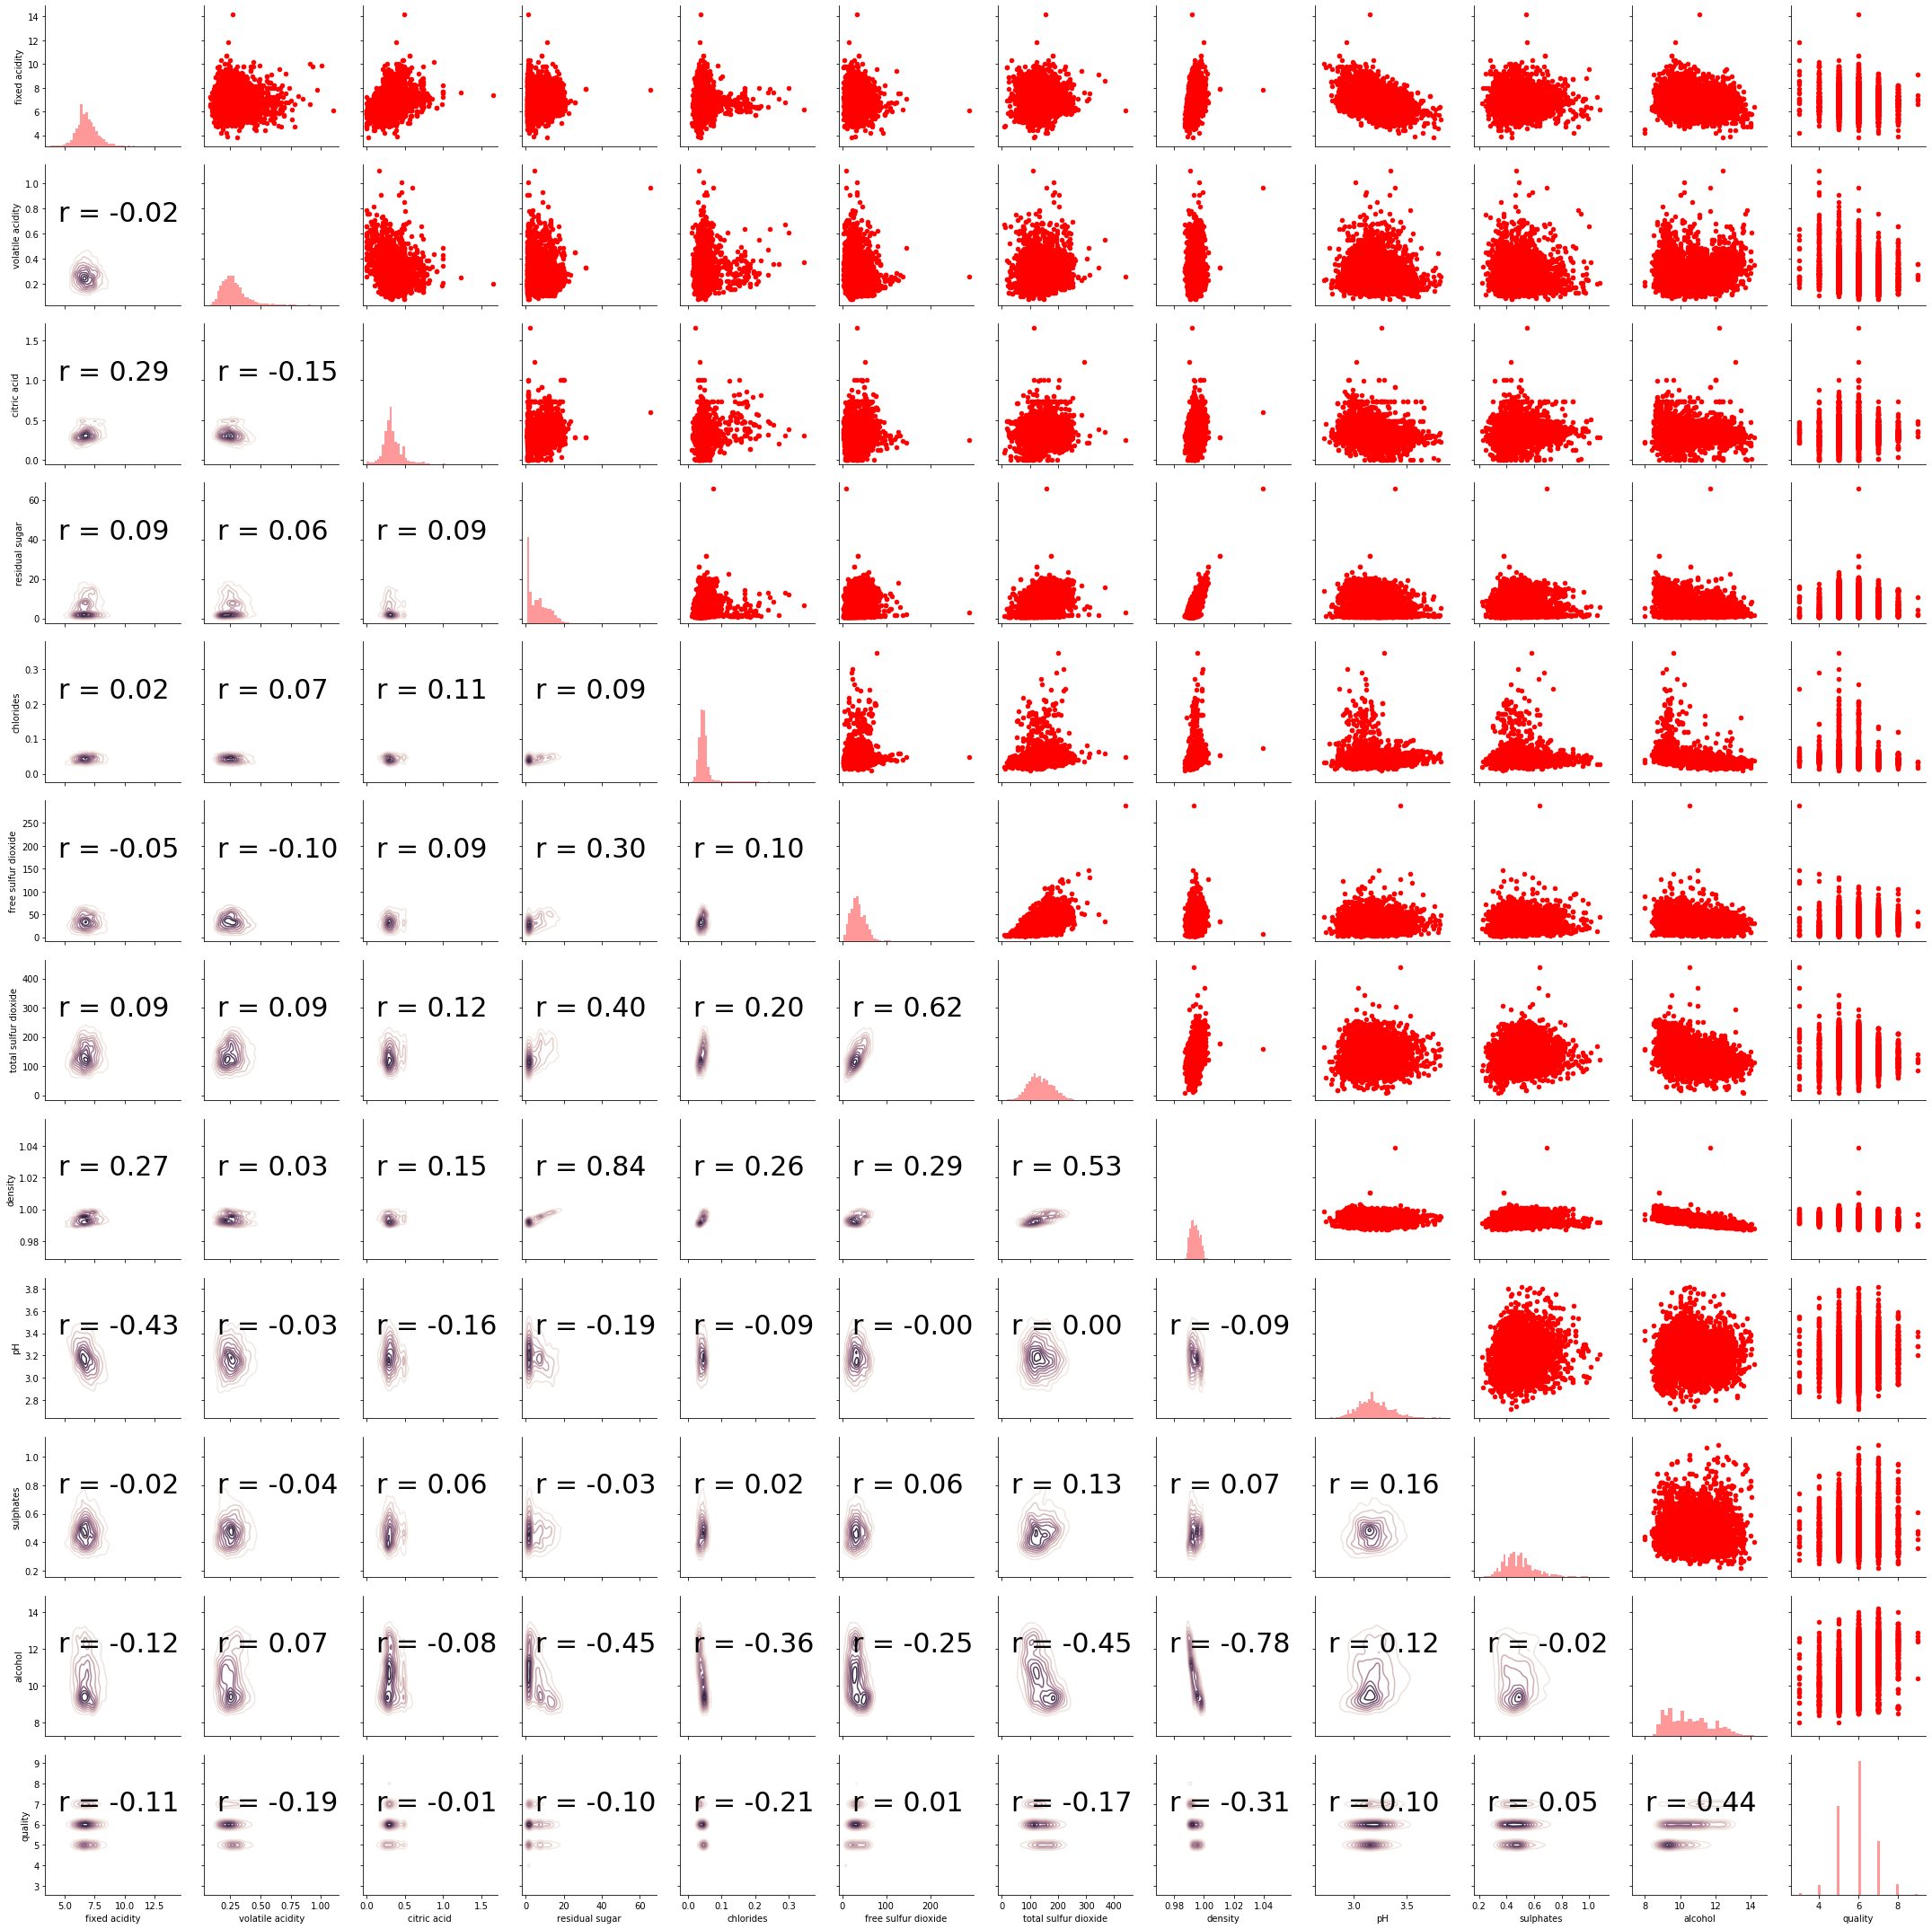

In [16]:
#generate pair plots for redundant features
def corrfunc(x, y, **kws):
    r,_ = stats.pearsonr(x,y)
    ax = plt.gca()
    ax.annotate("r = {:.2f}".format(r),
               xy=(.1, .6), xycoords=ax.transAxes,
               size = 30)
cmap = sns.cubehelix_palette(light=1, dark=0.1,
                            hue = 0.5, as_cmap=True)

sns.set_context(font_scale=2)

g = sns.PairGrid(df)

g.map_upper(plt.scatter, s=20, color='red')

g.map_diag(sns.distplot, kde=False, color='red')

g.map_lower(sns.kdeplot, cmap = cmap)
g.map_lower(corrfunc);

In [242]:
#drop redundant feature
X = X.drop(columns=['density', 'free sulfur dioxide'])
X.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,total sulfur dioxide,pH,sulphates,alcohol
0,7.0,0.27,0.36,20.7,0.045,170.0,3.00,0.45,8.8
1,6.3,0.30,0.34,1.6,0.049,132.0,3.30,0.49,9.5
2,8.1,0.28,0.40,6.9,0.050,97.0,3.26,0.44,10.1
3,7.2,0.23,0.32,8.5,0.058,186.0,3.19,0.40,9.9
4,7.2,0.23,0.32,8.5,0.058,186.0,3.19,0.40,9.9


In [240]:
#partition function to split data into train and test
def partition(X, y, t):
    test_rows_X = math.ceil(len(X)*t)
    test_rows_y = math.ceil(len(y)*t)
    train_rows_X = len(X) - test_rows_X
    train_rows_y = len(y) - test_rows_y
    X_train = X.iloc[:train_rows_X]
    X_test = X.iloc[train_rows_X:]
    y_train = y[0:train_rows_y]
    y_test = y[train_rows_y:len(y)]

    return np.asarray([X_train, y_train, X_test, y_test])
#partition(X, y, 0.2)

In [245]:
#use KNN_Classifier model on train data
knn = KNN_Classifier()
t = 0.2
n_neighbors = 5
X_train = partition(X, y, t)[0]
y_train = partition(X, y, t)[1]

knn.fit(X_train, y_train, n_neighbors,'uniform', {'Formula': 'Euclidean'})
y_train_predicted = knn.predict(X_train)

In [20]:
#check accuracy
accuracy = accu_error(y_train, y_train_predicted)[0]
print('The test accuracy is: ', accuracy)
#F1 score
f1 = f1_score(y_train, y_train_predicted)
print('\nThe F1 test score is: ', f1)

The test accuracy is:  0.8078101071975498

The F1 test score is:  0.860011154489682


In [21]:
#standardize the feature
X_test = partition(X, y, 0.2)[2]
y_test = partition(X, y, 0.2)[3]
X_train_mean = np.mean(X_train)
X_train_std = np.std(X_train)
y_train_mean = np.mean(y_train)
y_train_std = np.std(y_train)

X_train_standard = (X_train-X_train_mean)/(X_train_std)
X_test_standard = (X_test-X_train_mean)/(X_train_std)
y_train_standard = (y_train-y_train_mean)/(y_train_std)
y_test_standard = (y_test-y_train_mean)/(y_train_std)
#print(X_train_standard, X_test_standard)

In [22]:
#Re-run KNN_Classifier on standardized data
knn_std = KNN_Classifier()
t = 0.2
n_neighbors = 5
#X_train = partition(X, y, t)[0]
#y_train = partition(X, y, t)[1]

knn_std.fit(X_train_standard, y_train_standard, n_neighbors, 'uniform', {'Formula': 'Euclidean'})
y_train_std_predicted = knn_std.predict(X_train_standard)

In [23]:
#Find accuracy and f1 score for standardized data
accuracy_std = accu_error(y_train_standard, y_train_std_predicted)[0]
print('The standardized test accuracy is: ', accuracy_std)
f1_std = f1_score(y_train_standard, y_train_std_predicted)
print('\nThe standardized F1 test score is: ', f1_std)

The standardized test accuracy is:  0.2942904317103304

The standardized F1 test score is:  0


<font size=6 color=black>__Part C__</font>

In [244]:
def sPartition(folds,data):
    partitions = []
    size_of_folds = int(data.shape[0]/folds)
    for i in range(folds):
        partitions.append(data.head(size_of_folds))
        data = data.iloc[size_of_folds:,]
    return partitions
def sPartitionOfLabels(folds,labels):
    partitions = []
    size_of_folds = int(labels.shape[0]/folds)
    for i in range(folds):
        partitions.append(labels[0:size_of_folds])
        labels = np.delete(labels, range(0, size_of_folds-1), 0)
    return partitions

def sFold(folds,data,labels,model,model_args,error_function):
    partitions = sPartition(folds,data)
    partitions_of_labels = sPartitionOfLabels(folds,labels)
    size_of_folds = int(data.shape[0]/folds)
    expected_labels = []
    predicted_labels = []
    all_errors = []
    k_value = model_args['k']
    weights = model_args['weights']
    
    average_error = 0
    for i in range(len(partitions)):
        start = i*size_of_folds
        fin = start + size_of_folds
        all_other_partitions = data.drop(data.index[start:fin])
        all_other_labels = np.delete(labels, range(start, fin), 0)
        expected_labels.append(partitions_of_labels[i])
        model.fit(all_other_partitions, all_other_labels, k_value, weights, model_args)
        predicted_labels.append(model.predict(partitions[i]))
    for i in range(len(partitions)):
        all_errors.append(f1_score(expected_labels[i], predicted_labels[i]))
    average_error = np.mean(all_errors)
    return {'Expected labels':expected_labels,'Predicted labels':predicted_labels,'Average error':average_error}

In [25]:
knn = KNN_Classifier()
results = []
results.append(sFold(5,X_train,y_train,knn,{'k':1,'weights':'uniform','Formula':'Euclidean'},f1_score))
results.append(sFold(5,X_train,y_train,knn,{'k':5,'weights':'uniform','Formula':'Euclidean'},f1_score))
results.append(sFold(5,X_train,y_train,knn,{'k':9,'weights':'uniform','Formula':'Euclidean'},f1_score))
results.append(sFold(5,X_train,y_train,knn,{'k':11,'weights':'uniform','Formula':'Euclidean'},f1_score))
results.append(sFold(5,X_train,y_train,knn,{'k':1,'weights':'uniform','Formula':'Manhattan'},f1_score))
results.append(sFold(5,X_train,y_train,knn,{'k':5,'weights':'uniform','Formula':'Manhattan'},f1_score))
results.append(sFold(5,X_train,y_train,knn,{'k':9,'weights':'uniform','Formula':'Manhattan'},f1_score))
results.append(sFold(5,X_train,y_train,knn,{'k':11,'weights':'uniform','Formula':'Manhatten'},f1_score))

In [291]:
avg_error_list = []
for i in range(len(results)):
    avg_error = results[i].get('Average error')
    avg_error_list.append(avg_error)
min_error = min(avg_error_list)
print(avg_error_list)
optimal_model = None
for i in range(len(results)):
    if results[i].get('Average error') == min_error:
        optimal_model = i
print('\nThe optimal solution is combination: ', optimal_model+1)
#The best model is combination 1

[0.6629580479966057, 0.7102011598419258, 0.7189102978304016, 0.7216933526575284, 0.669781867119448, 0.7056999505754926, 0.7163287489005563, 0.7178342694616932]

The optimal solution is combination:  1


In [46]:
#Evaluate model
knn_optimal = KNN_Classifier()
knn_optimal.fit(X_train, y_train, 1, 'uniform', {'Formula':'Euclidean'})
y_pred_optimal = knn.predict(X_test)

In [74]:
precision_optimal = precision(y_test, y_pred_optimal)
print('\nThe precision of the best model is: ', precision_optimal)
recall_optimal = recall(y_test, y_pred_optimal)
print('\nThe recall of the best model is: ', recall_optimal)
f1_optimal = f1_score(y_test, y_pred_optimal)
print('\nThe F1 score of the best model is: ', f1_optimal)

confusion_optimal = confusion_matrix(y_test, y_pred_optimal)
print('\nConfusion Matrix:\n', confusion_optimal)

accu_optimal = accu_error(y_test, y_pred_optimal)[0]
print('\nThe accuracy of the best model is: ', accu_optimal)


The precision of the best model is:  0.7413127413127413

The recall of the best model is:  0.8372093023255814

The F1 score of the best model is:  0.7863481228668943

Confusion Matrix:
 [[ 91 201]
 [112 576]]

The accuracy of the best model is:  0.6806122448979592


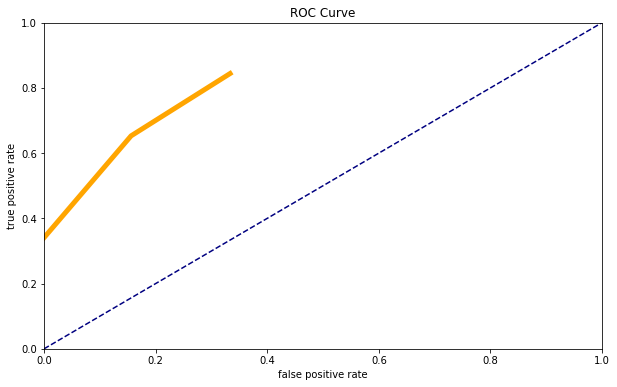

In [300]:
rate_lists('Euclidean', 5, X, X_train, y_train)
ROC_curve(fpr, tpr)  

In [302]:
auc(fpr,tpr)

-0.21024244914731866

In [286]:
st.t.interval(0.95, len(y_train_predicted)-1, loc=np.mean(y_train_predicted), scale=st.sem(y_train_predicted))

(0.7028356116974321, 0.7310592326108885)